# Рекуррентные нейросети. Группа ИАД-5

<img src="https://habrastorage.org/web/a9b/1e6/40f/a9b1e640f6264b0a902e851eb5f29e08.png" width="150px">
<img src="https://habrastorage.org/web/5c8/0fa/c22/5c80fac224d449209d888d18ea1111a8.png" width="600px">

# Простая RNN для предсказания временных рядов

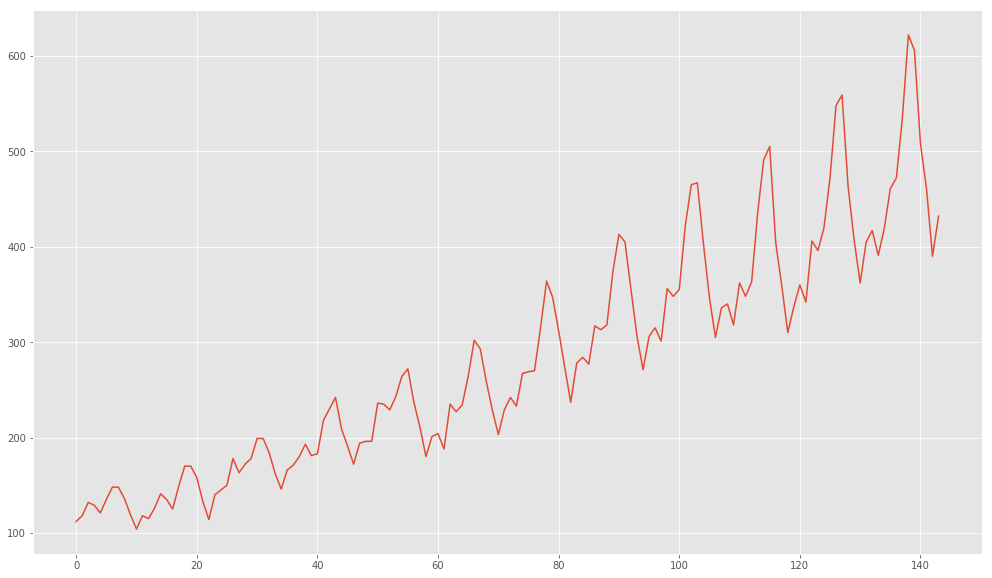

In [1]:
import pandas
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')
%matplotlib inline

from pylab import rcParams
rcParams['figure.figsize'] = 17, 10

dataset = pandas.read_csv('https://github.com/lazyprogrammer/machine_learning_examples/raw/master/airline/international-airline-passengers.csv', 
                          usecols=[1], engine='python', skipfooter=3)
plt.plot(dataset)
plt.show()

In [2]:
import numpy
import matplotlib.pyplot as plt
import pandas
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import SimpleRNN
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error


# зафиксируем random_state для дальнейшей воспроизводимости эксперимента
numpy.random.seed(7)

dataset = dataset.values # Keras умеет хавать только numpy-матрицы
dataset = dataset.astype('float32')


# приведём все данные к интервалу значений от 0 до 1 (нормализуем)
# В принципе, если вы не используете регуляризацию, то можно не нормировать - результат будет тот же
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

# разобьём данные на трейн и тест. 
# В задачах предсказания временный рядов это нужно делать осторожно, чтобы случайно не перемешать порядок данных!
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

print(train)
# сконвертируем данные таким образом, чтобы для каждого временного тика (начиная с look_back) были добавлены 
# признаки для look_back предыдущих состояний
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return numpy.array(dataX), numpy.array(dataY)

look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

Using Theano backend.
DEBUG: nvcc STDOUT nvcc warning : The 'compute_20', 'sm_20', and 'sm_21' architectures are deprecated, and may be removed in a future release (Use -Wno-deprecated-gpu-targets to suppress warning).
mod.cu
   Создается библиотека C:/Users/sanek/AppData/Local/Theano/compiledir_Windows-10-10.0.15063-SP0-Intel64_Family_6_Model_78_Stepping_3_GenuineIntel-3.5.4-64/tmpr13eg3g6/m91973e5c136ea49268a916ff971b7377.lib и объект C:/Users/sanek/AppData/Local/Theano/compiledir_Windows-10-10.0.15063-SP0-Intel64_Family_6_Model_78_Stepping_3_GenuineIntel-3.5.4-64/tmpr13eg3g6/m91973e5c136ea49268a916ff971b7377.exp

Using gpu device 0: GeForce GPU (CNMeM is disabled, cuDNN 5110)
C:\Users\sanek\Anaconda3\lib\site-packages\theano-0.8.2-py3.5.egg\theano\sandbox\cuda\__init__.py:600: UserWarning: Your cuDNN version is more recent than the one Theano officially supports. If you see any problems, try updating Theano or downgrading cuDNN to version 5.
  warnings.warn(warn)


96 48
[[ 0.01544401]
 [ 0.02702703]
 [ 0.05405405]
 [ 0.04826255]
 [ 0.03281853]
 [ 0.05984557]
 [ 0.08494207]
 [ 0.08494207]
 [ 0.06177607]
 [ 0.02895753]
 [ 0.        ]
 [ 0.02702703]
 [ 0.02123553]
 [ 0.04247104]
 [ 0.07142857]
 [ 0.05984557]
 [ 0.04054055]
 [ 0.08687258]
 [ 0.12741312]
 [ 0.12741312]
 [ 0.10424709]
 [ 0.05598456]
 [ 0.01930502]
 [ 0.06949806]
 [ 0.07915059]
 [ 0.08880308]
 [ 0.14285713]
 [ 0.11389962]
 [ 0.13127413]
 [ 0.14285713]
 [ 0.18339768]
 [ 0.18339768]
 [ 0.15444016]
 [ 0.11196911]
 [ 0.08108109]
 [ 0.1196911 ]
 [ 0.12934363]
 [ 0.14671814]
 [ 0.17181468]
 [ 0.14864865]
 [ 0.15250966]
 [ 0.22007722]
 [ 0.24324325]
 [ 0.26640925]
 [ 0.2027027 ]
 [ 0.16795367]
 [ 0.13127413]
 [ 0.17374519]
 [ 0.17760617]
 [ 0.17760617]
 [ 0.25482625]
 [ 0.25289574]
 [ 0.24131274]
 [ 0.26833975]
 [ 0.3088803 ]
 [ 0.32432434]
 [ 0.25675675]
 [ 0.20656371]
 [ 0.14671814]
 [ 0.18725869]
 [ 0.19305018]
 [ 0.16216215]
 [ 0.25289574]
 [ 0.23745173]
 [ 0.25096524]
 [ 0.3088803 ]
 [ 0

In [3]:
# LSTM и RNN умеет работать с данными в таком формате [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [4]:
# А вот и вся наша нейросетка :)
model = Sequential()
model.add(SimpleRNN(4, batch_input_shape=(1, look_back, 1))) # 4 - размерность выхода, batch_input_shape = [batch_size, time steps, features]
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)

DEBUG: nvcc STDOUT mod.cu
   Создается библиотека C:/Users/sanek/AppData/Local/Theano/compiledir_Windows-10-10.0.15063-SP0-Intel64_Family_6_Model_78_Stepping_3_GenuineIntel-3.5.4-64/tmpirw8zjyz/mc12b8f0fe265b1ada8bce924bc0f113d.lib и объект C:/Users/sanek/AppData/Local/Theano/compiledir_Windows-10-10.0.15063-SP0-Intel64_Family_6_Model_78_Stepping_3_GenuineIntel-3.5.4-64/tmpirw8zjyz/mc12b8f0fe265b1ada8bce924bc0f113d.exp

DEBUG: nvcc STDOUT mod.cu
   Создается библиотека C:/Users/sanek/AppData/Local/Theano/compiledir_Windows-10-10.0.15063-SP0-Intel64_Family_6_Model_78_Stepping_3_GenuineIntel-3.5.4-64/tmpq0t9hl9t/m29fa61dbf36ea25b718dd35028bcaa9d.lib и объект C:/Users/sanek/AppData/Local/Theano/compiledir_Windows-10-10.0.15063-SP0-Intel64_Family_6_Model_78_Stepping_3_GenuineIntel-3.5.4-64/tmpq0t9hl9t/m29fa61dbf36ea25b718dd35028bcaa9d.exp

DEBUG: nvcc STDOUT mod.cu
   Создается библиотека C:/Users/sanek/AppData/Local/Theano/compiledir_Windows-10-10.0.15063-SP0-Intel64_Family_6_Model_78_Ste

DEBUG: nvcc STDOUT mod.cu
   Создается библиотека C:/Users/sanek/AppData/Local/Theano/compiledir_Windows-10-10.0.15063-SP0-Intel64_Family_6_Model_78_Stepping_3_GenuineIntel-3.5.4-64/tmp1gnwx197/m4029c47eda4abd8feea295582c6c566d.lib и объект C:/Users/sanek/AppData/Local/Theano/compiledir_Windows-10-10.0.15063-SP0-Intel64_Family_6_Model_78_Stepping_3_GenuineIntel-3.5.4-64/tmp1gnwx197/m4029c47eda4abd8feea295582c6c566d.exp

DEBUG: nvcc STDOUT mod.cu
   Создается библиотека C:/Users/sanek/AppData/Local/Theano/compiledir_Windows-10-10.0.15063-SP0-Intel64_Family_6_Model_78_Stepping_3_GenuineIntel-3.5.4-64/tmpgaxlwme8/m6188fe81664f3f651254e2ae29967e62.lib и объект C:/Users/sanek/AppData/Local/Theano/compiledir_Windows-10-10.0.15063-SP0-Intel64_Family_6_Model_78_Stepping_3_GenuineIntel-3.5.4-64/tmpgaxlwme8/m6188fe81664f3f651254e2ae29967e62.exp

DEBUG: nvcc STDOUT mod.cu
   Создается библиотека C:/Users/sanek/AppData/Local/Theano/compiledir_Windows-10-10.0.15063-SP0-Intel64_Family_6_Model_78_Ste

DEBUG: nvcc STDOUT mod.cu
   Создается библиотека C:/Users/sanek/AppData/Local/Theano/compiledir_Windows-10-10.0.15063-SP0-Intel64_Family_6_Model_78_Stepping_3_GenuineIntel-3.5.4-64/tmp3ur81taz/m8285c94df19b44ba388e65dc69110924.lib и объект C:/Users/sanek/AppData/Local/Theano/compiledir_Windows-10-10.0.15063-SP0-Intel64_Family_6_Model_78_Stepping_3_GenuineIntel-3.5.4-64/tmp3ur81taz/m8285c94df19b44ba388e65dc69110924.exp

DEBUG: nvcc STDOUT mod.cu
   Создается библиотека C:/Users/sanek/AppData/Local/Theano/compiledir_Windows-10-10.0.15063-SP0-Intel64_Family_6_Model_78_Stepping_3_GenuineIntel-3.5.4-64/tmp8yxjmesl/m0d52253979a58a88a170a121915524e5.lib и объект C:/Users/sanek/AppData/Local/Theano/compiledir_Windows-10-10.0.15063-SP0-Intel64_Family_6_Model_78_Stepping_3_GenuineIntel-3.5.4-64/tmp8yxjmesl/m0d52253979a58a88a170a121915524e5.exp

DEBUG: nvcc STDOUT mod.cu
   Создается библиотека C:/Users/sanek/AppData/Local/Theano/compiledir_Windows-10-10.0.15063-SP0-Intel64_Family_6_Model_78_Ste

DEBUG: nvcc STDOUT mod.cu
   Создается библиотека C:/Users/sanek/AppData/Local/Theano/compiledir_Windows-10-10.0.15063-SP0-Intel64_Family_6_Model_78_Stepping_3_GenuineIntel-3.5.4-64/tmpyu4me9hi/mbae021aa4f2f07d666a962b641c6ff11.lib и объект C:/Users/sanek/AppData/Local/Theano/compiledir_Windows-10-10.0.15063-SP0-Intel64_Family_6_Model_78_Stepping_3_GenuineIntel-3.5.4-64/tmpyu4me9hi/mbae021aa4f2f07d666a962b641c6ff11.exp

DEBUG: nvcc STDOUT mod.cu
   Создается библиотека C:/Users/sanek/AppData/Local/Theano/compiledir_Windows-10-10.0.15063-SP0-Intel64_Family_6_Model_78_Stepping_3_GenuineIntel-3.5.4-64/tmp7ix1k8d8/m5daa942257672b727db9d52b119c8c50.lib и объект C:/Users/sanek/AppData/Local/Theano/compiledir_Windows-10-10.0.15063-SP0-Intel64_Family_6_Model_78_Stepping_3_GenuineIntel-3.5.4-64/tmp7ix1k8d8/m5daa942257672b727db9d52b119c8c50.exp

DEBUG: nvcc STDOUT mod.cu
   Создается библиотека C:/Users/sanek/AppData/Local/Theano/compiledir_Windows-10-10.0.15063-SP0-Intel64_Family_6_Model_78_Ste

Epoch 1/100
0s - loss: 0.0754
Epoch 2/100
0s - loss: 0.0294
Epoch 3/100
0s - loss: 0.0232
Epoch 4/100
0s - loss: 0.0193
Epoch 5/100
0s - loss: 0.0159
Epoch 6/100
0s - loss: 0.0129
Epoch 7/100
0s - loss: 0.0100
Epoch 8/100
0s - loss: 0.0076
Epoch 9/100
0s - loss: 0.0058
Epoch 10/100
0s - loss: 0.0045
Epoch 11/100
0s - loss: 0.0035
Epoch 12/100
0s - loss: 0.0029
Epoch 13/100
0s - loss: 0.0025
Epoch 14/100
0s - loss: 0.0023
Epoch 15/100
0s - loss: 0.0022
Epoch 16/100
0s - loss: 0.0021
Epoch 17/100
0s - loss: 0.0020
Epoch 18/100
0s - loss: 0.0020
Epoch 19/100
0s - loss: 0.0020
Epoch 20/100
0s - loss: 0.0020
Epoch 21/100
0s - loss: 0.0020
Epoch 22/100
0s - loss: 0.0020
Epoch 23/100
0s - loss: 0.0021
Epoch 24/100
0s - loss: 0.0020
Epoch 25/100
0s - loss: 0.0020
Epoch 26/100
0s - loss: 0.0020
Epoch 27/100
0s - loss: 0.0020
Epoch 28/100
0s - loss: 0.0019
Epoch 29/100
0s - loss: 0.0019
Epoch 30/100
0s - loss: 0.0020
Epoch 31/100
0s - loss: 0.0020
Epoch 32/100
0s - loss: 0.0020
Epoch 33/100
0s -

In [5]:
# получим предсказания
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# преобразуем обратно наши данные из интервала (0, 1) в исходных диапазон значений
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# посчитаем MSE для наших предсказаний
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

DEBUG: nvcc STDOUT mod.cu
   Создается библиотека C:/Users/sanek/AppData/Local/Theano/compiledir_Windows-10-10.0.15063-SP0-Intel64_Family_6_Model_78_Stepping_3_GenuineIntel-3.5.4-64/tmp1w9fy6vx/m4ed83a0f44ca2192093d41fe91854c60.lib и объект C:/Users/sanek/AppData/Local/Theano/compiledir_Windows-10-10.0.15063-SP0-Intel64_Family_6_Model_78_Stepping_3_GenuineIntel-3.5.4-64/tmp1w9fy6vx/m4ed83a0f44ca2192093d41fe91854c60.exp

DEBUG: nvcc STDOUT mod.cu
   Создается библиотека C:/Users/sanek/AppData/Local/Theano/compiledir_Windows-10-10.0.15063-SP0-Intel64_Family_6_Model_78_Stepping_3_GenuineIntel-3.5.4-64/tmp2k7lampy/m72021b897d9086a1f8f77193017b6764.lib и объект C:/Users/sanek/AppData/Local/Theano/compiledir_Windows-10-10.0.15063-SP0-Intel64_Family_6_Model_78_Stepping_3_GenuineIntel-3.5.4-64/tmp2k7lampy/m72021b897d9086a1f8f77193017b6764.exp

DEBUG: nvcc STDOUT mod.cu
   Создается библиотека C:/Users/sanek/AppData/Local/Theano/compiledir_Windows-10-10.0.15063-SP0-Intel64_Family_6_Model_78_Ste

Train Score: 23.43 RMSE
Test Score: 61.10 RMSE


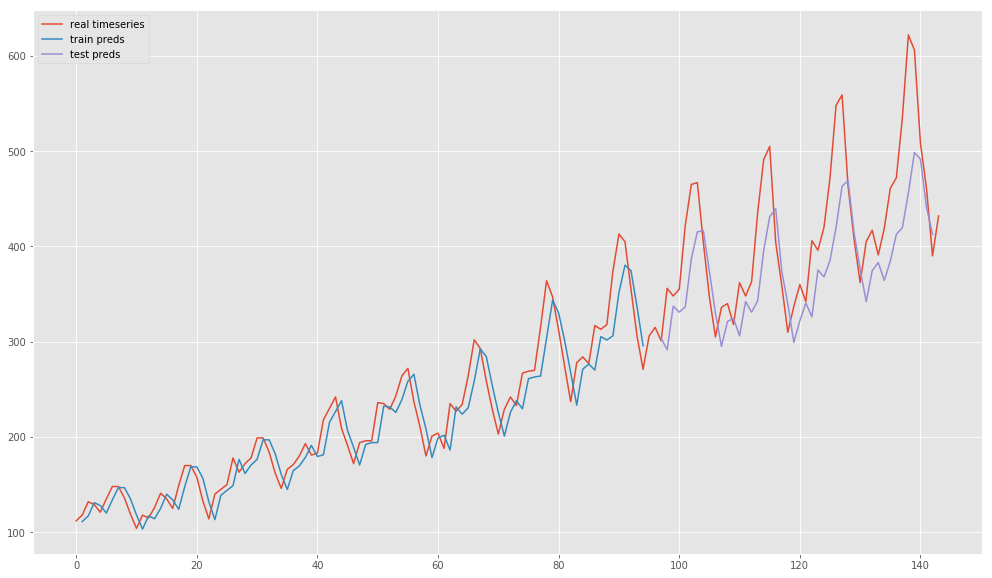

In [6]:
# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset), label='real timeseries')
plt.plot(trainPredictPlot, label='train preds')
plt.plot(testPredictPlot, label='test preds')
plt.legend()
plt.show()

# Сброс состояний перед каждым обучением

## Упражнение 1

In [ ]:
# TODO: проделываем те же махинации до стадии с обучением

In [ ]:
# Обучаем со сбросом состояний
for epoch in range(NB_EPOCHES):
    model.fit(trainX, trainY, epochs=1, batch_size=1, verbose=0)
    model.reset_states()

In [ ]:
# TODO: посмотрите на качество предсказаний

## LSTM
![lstm](https://habrastorage.org/web/67b/04f/73b/67b04f73b4c34ba38edfa207e09de07c.png)

## Упражнение 2

In [ ]:
from keras.layers import LSTM

# TODO проделайте все те же телодвижения с LSTM. Проверьте, есть ли прирост качества, и объясните полученные результаты

## Упражнение 3

In [ ]:
from keras.datasets import imdb
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence

top_words = 5000
(X_train, y_train), (X_test, y_test) = imdb.load_data(nb_words=top_words)

Приводим все к одной форме

In [ ]:
max_review_length = 500
X_train = sequence.pad_sequences(X_train, maxlen=max_review_length)
X_test = sequence.pad_sequences(X_test, maxlen=max_review_length)

In [1]:
# Создаем модель Embedding(top_words, embedding_vecor_length, input_length=max_review_length)+ LSTM(100)+Dense sigmoid, binary_crossentropy, ADAM, accuracy

In [2]:
# Обучаем с validation_data и epochs=3, batch_size=64

In [3]:
# считаем score

# Полезные ссылки
* [Статья](https://habrahabr.ru/company/wunderfund/blog/331310/) про RNN и LSTM на Хабре
* Годная [статья](https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/) с подробным разбором примера на Keras